In [71]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [72]:
class DeepReLUNet(nn.Module):
    def __init__(self, depth=2, width=2):
        super().__init__()
        layers = []
        layers.append(nn.Linear(2, width))
        layers.append(nn.ReLU())

        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(width, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x, return_activation=False, return_feat=False):
        activations = []
        feat = None
        h = x
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                feat = h
                h = layer(h)
            elif isinstance(layer, nn.ReLU):
                activations.append((h > 0).int())
                h = layer(h)

        if return_activation:
            return h, torch.cat(activations, dim=1)
        if return_feat:
            return h, feat
        return h

In [73]:
def init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0.0, std=1.0)
            nn.init.uniform_(m.bias, -0.5, 0.5)

In [74]:
def sample_grid(n=300, lim=3.0):
    xs = np.linspace(-lim, lim, n)
    ys = np.linspace(-lim, lim, n)
    xx, yy = np.meshgrid(xs, ys)
    pts = np.stack([xx.ravel(), yy.ravel()], axis=1)
    return xx, yy, torch.tensor(pts, dtype=torch.float32)

In [75]:
def compute_cell_ids(model, x):
    with torch.no_grad():
        _, activation = model(x, return_activation=False, return_feat=True)
    # 把 activation pattern 映射为整数 hash
    powers = 2 ** torch.arange(activation.shape[1])
    cell_id = (activation * powers).sum(dim=1)
    return cell_id.cpu().numpy()
    # return [hash(tuple(a.tolist())) for a in activation]

In [76]:
def visualize_cells(depth):
    model = DeepReLUNet(depth=depth, width=6)
    init_weights(model)

    xx, yy, pts = sample_grid()
    cell_ids = compute_cell_ids(model, pts)
    cell_ids = cell_ids.reshape(xx.shape)
    # cell_hash = compute_cell_ids(model, pts)
    # cell_hash = np.array(cell_hash).reshape(xx.shape)

    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, cell_ids, levels=50, cmap="tab20")
    plt.colorbar(label="Polyhedral Cell ID")
    plt.title(f"Polyhedral Cells (Depth = {depth})")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

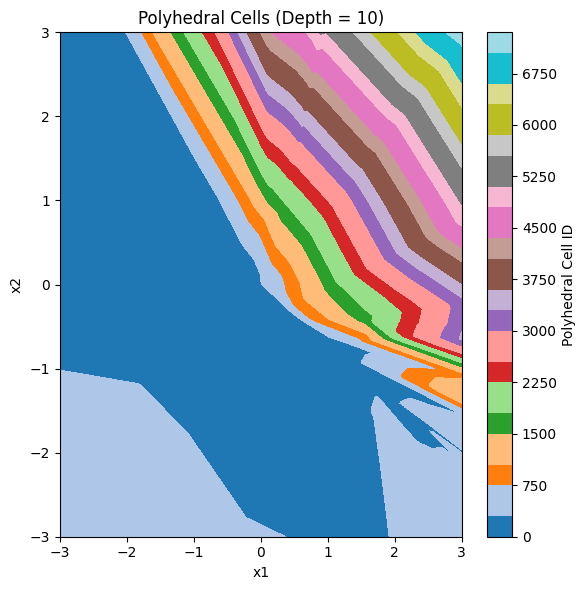

In [77]:
for depth in [
    10,
]:
    visualize_cells(depth)